# Ground Projection

In [19]:
%load_ext autoreload
%autoreload 2

from dt_computer_vision.camera import CameraModel

from dt_computer_vision.camera.calibration.extrinsics.boards import CalibrationBoard8by6
from dt_computer_vision.ground_projection.rendering import debug_image
from dt_computer_vision_tests.line_detection_tests.test_detection import detect_color
from dt_computer_vision.ground_projection import GroundProjector

from dt_computer_vision.ground_projection.types import GroundPoint
from dt_computer_vision.camera import Pixel, NormalizedImagePoint

import os
import cv2
import numpy as np

import matplotlib.pyplot as plt

import matplotlib as mpl

mpl.rc("figure", dpi=200)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
this_dir: str = os.path.abspath('')
assets_dir: str = os.path.join(this_dir, "..", "assets")
image_fpath: str = os.path.join(assets_dir, f"image0.jpg")
image_orig: np.ndarray = cv2.imread(image_fpath)
board = CalibrationBoard8by6

camera_properties = {
    "width": 640,
    "height": 480,
    "K": [[295.79606866959824, 0.0, 321.2621599038631],
          [0.0, 299.5389048862878, 241.73616515312332],
          [0.0, 0.0, 1.0]],
    "D": [-0.23543978771661125,
          0.03637781479419574,
          -0.0033069818601306755,
          -0.0012140708179525926,
          0.0],
    "P": [[201.14027404785156, 0.0, 319.5586620845679, 0.0],
          [0.0, 239.74398803710938, 237.60151004037834, 0.0],
          [0.0, 0.0, 1.0, 0.0]],
    # NOTE: this homography is computed in the 20-entrinsics-calibration jupyter notebook
    "H": [  [ 0.45484525,  0.33783685,  0.11218921],
            [-0.02801287,  1.02463437, -0.07835274],
            [-0.19216963,  3.63163831,  1.        ]]
}

assert image_orig.shape == (480, 640, 3)

In [21]:
# create camera
camera = CameraModel(**camera_properties)
projector = GroundProjector(camera)

# We can also avoid normalizing the segments in the projection loop by using the `pixel2vector` homography
camera1 = CameraModel(**camera_properties)
camera1.H = camera1.H @ camera.homography_pixel2vector()

projector_direct = GroundProjector(camera1)


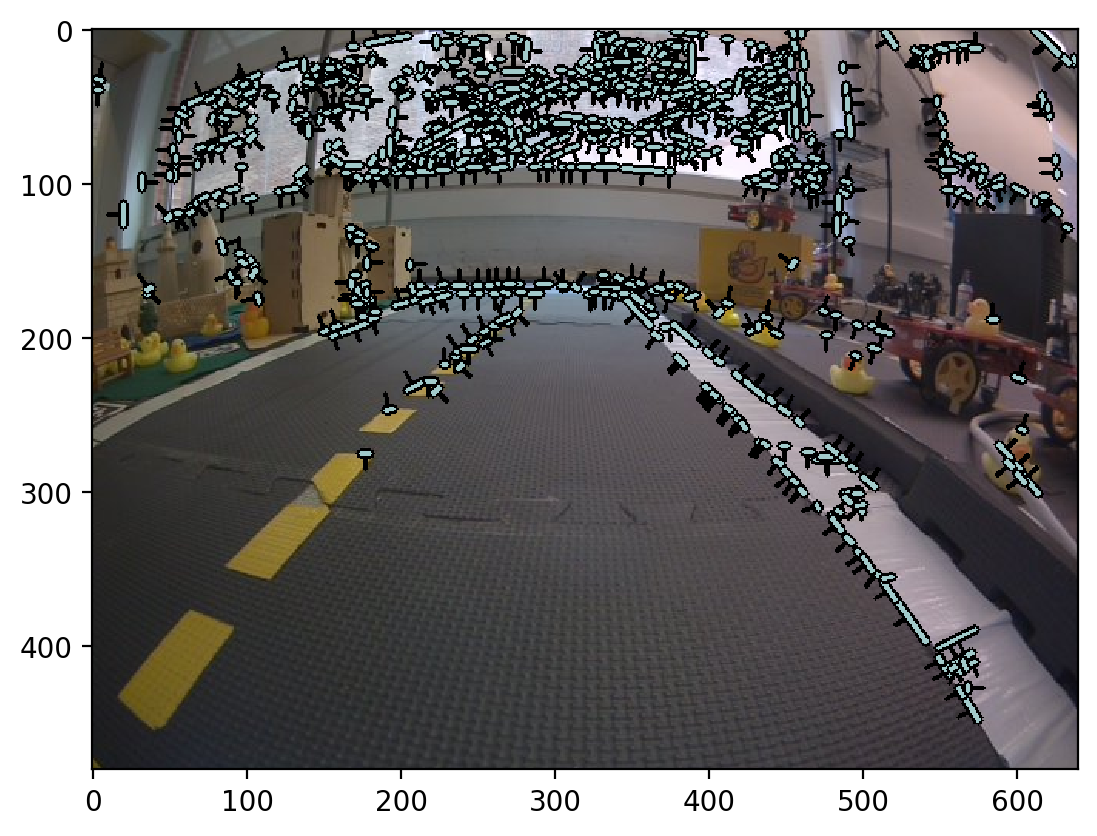

In [22]:
# detect segments
color: str = "white"
segments, image_w_detections = detect_color(image_orig, color)

# draw segments
image_w_detections = cv2.cvtColor(image_w_detections, cv2.COLOR_BGR2RGB)
plt.imshow(image_w_detections)

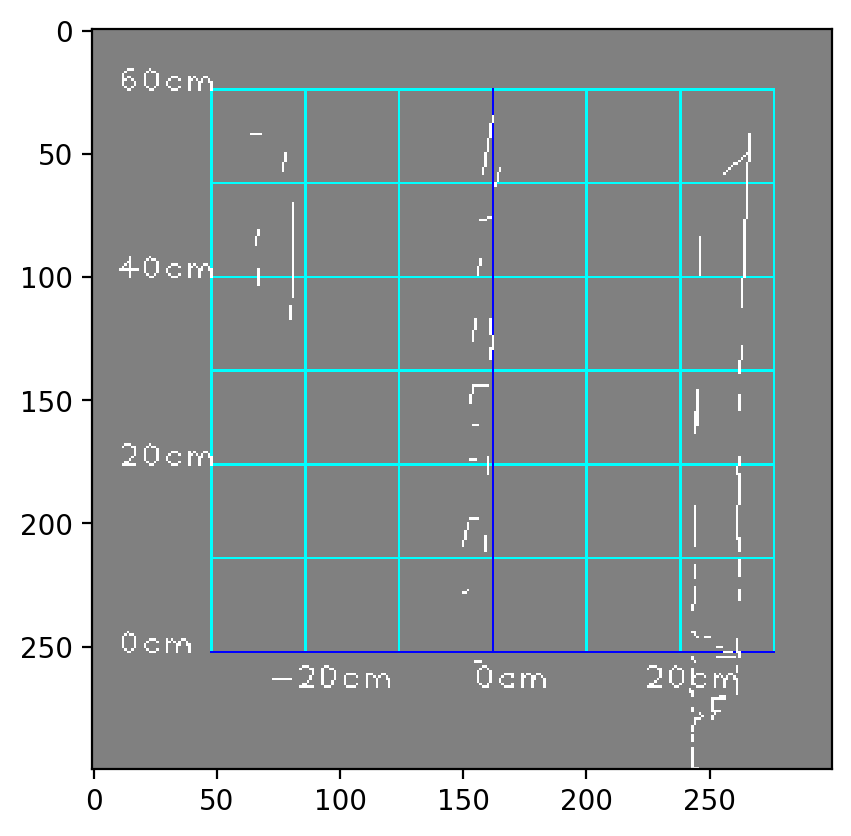

In [23]:
# project segments onto the ground plane
colored_segments = {(255, 255, 255): []}

for segment in segments.lines:
    # distorted pixels
    p0: Pixel = Pixel(segment[0], segment[1])
    p1: Pixel = Pixel(segment[2], segment[3])
    # print(p0)
    # distorted pixels to rectified pixels
    p0_rect: Pixel = camera.rectifier.rectify_pixel(p0)
    p1_rect: Pixel = camera.rectifier.rectify_pixel(p1)
    # print(p0_rect)
    # rectified pixel to normalized coordinates
    p0_norm: NormalizedImagePoint = camera.pixel2vector(p0_rect)
    p1_norm: NormalizedImagePoint = camera.pixel2vector(p1_rect)
    # print(p0_norm)
    # project image point onto the ground plane
    p0_ground: GroundPoint = projector.vector2ground(p0_norm)
    p1_ground: GroundPoint = projector.vector2ground(p1_norm)

    p0_ground_direct = projector_direct.vector2ground(p0_rect)
    p1_ground_direct = projector_direct.vector2ground(p1_rect)

    assert np.allclose(
        p0_ground_direct.as_array(), p0_ground.as_array()
    ), f"The points are not close {p0_ground_direct.as_array()} != {p0_ground.as_array()}"
    assert np.allclose(
        p1_ground_direct.as_array(), p1_ground.as_array()
    ), f"The points are not close {p1_ground_direct.as_array()} != {p1_ground.as_array()}"

    # add grounded segment to output
    colored_segments[(255, 255, 255)].append((p0_ground, p1_ground))

image_w_projected_segments = debug_image(
    colored_segments, (300, 300), grid_size=6, s_segment_thickness=2, resolution=0.1
)
image_w_projected_segments = cv2.cvtColor(image_w_projected_segments, cv2.COLOR_BGR2RGB)

plt.imshow(image_w_projected_segments)


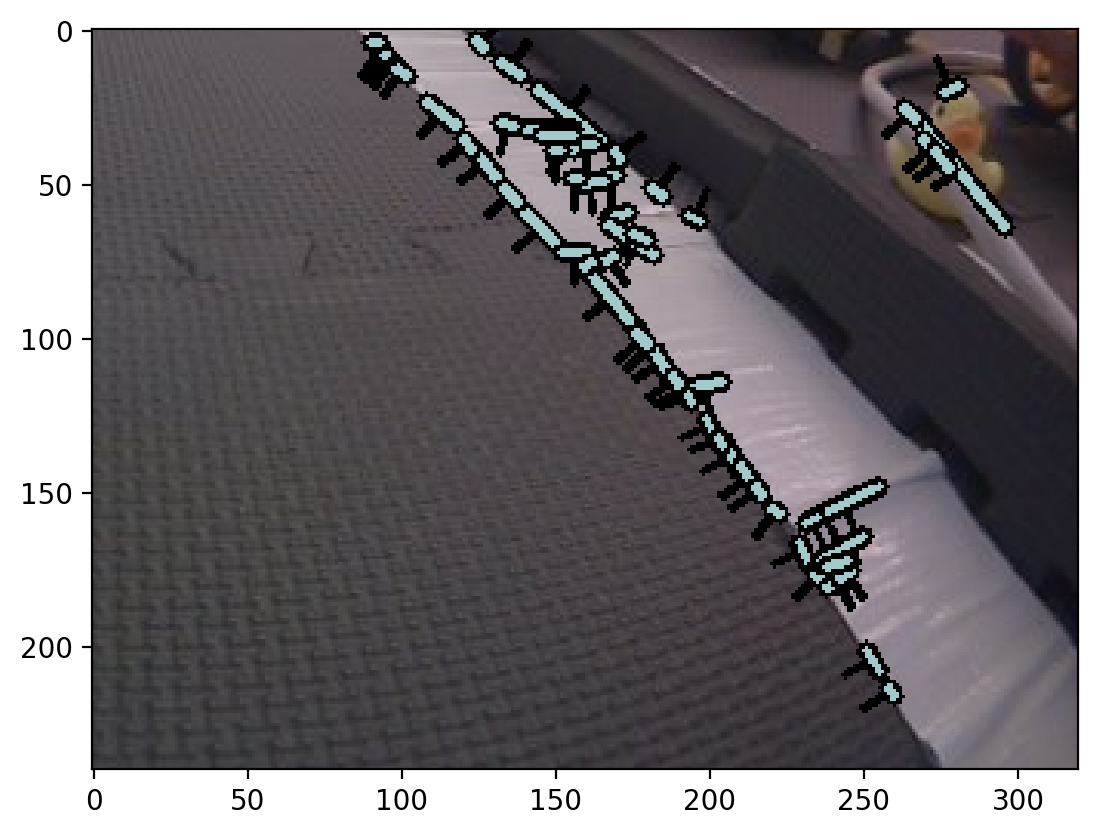

In [24]:
from copy import deepcopy

# define cropping
crop_x_amount = 0.5
crop_y_amount = 0.5

# create new camera parameters
crop_x = int(image_orig.shape[1] * crop_x_amount)
crop_y = int(image_orig.shape[0] * crop_y_amount)
camera_params_orig = deepcopy(camera_properties)
camera_params_cropped = deepcopy(camera_properties)
camera_params_cropped["K"][0][2] -= crop_x
camera_params_cropped["K"][1][2] -= crop_y

# TODO: this should be using the rectified cx, cy instead
camera_params_cropped["P"][0][2] -= crop_x
camera_params_cropped["P"][1][2] -= crop_y

# crop image
image_cropped = image_orig[crop_y:, crop_x:, :]
assert image_cropped.shape == (image_orig.shape[0] - crop_y, image_orig.shape[1] - crop_x, image_orig.shape[2])

# update camera
camera_cropped = CameraModel(**camera_params_cropped)
projector_cropped = GroundProjector(camera_cropped)

# detect segments
color: str = "white"
segments_cropped, image_w_detections_cropped = detect_color(image_cropped, color)

# draw segments
image_w_detections_cropped = cv2.cvtColor(image_w_detections_cropped, cv2.COLOR_BGR2RGB)
plt.imshow(image_w_detections_cropped)

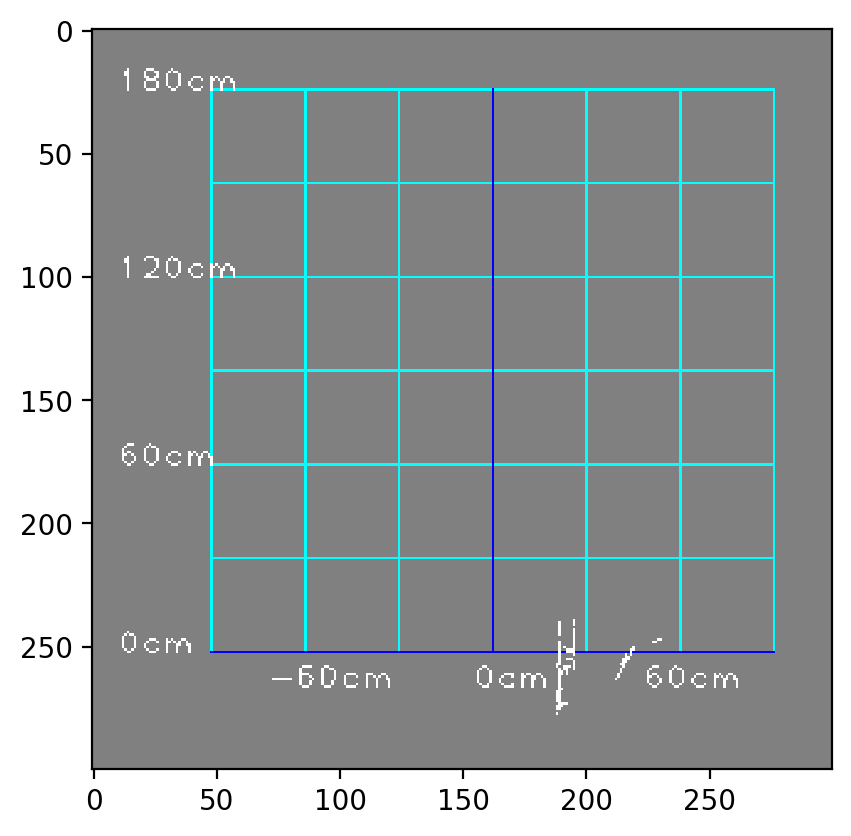

In [25]:
# project segments onto the ground plane
colored_segments_cropped = {
    (255, 255, 255): []
}

for segment in segments_cropped.lines:
    # distorted pixels
    p0: Pixel = Pixel(segment[0], segment[1])
    p1: Pixel = Pixel(segment[2], segment[3])
    #print(p0)
    # distorted pixels to rectified pixels
    p0_rect: Pixel = camera_cropped.rectifier.rectify_pixel(p0)
    p1_rect: Pixel = camera_cropped.rectifier.rectify_pixel(p1)
    #print(p0_rect)
    # rectified pixel to normalized coordinates
    p0_norm: NormalizedImagePoint = camera_cropped.pixel2vector(p0_rect)
    p1_norm: NormalizedImagePoint = camera_cropped.pixel2vector(p1_rect)
    #print(p0_norm)
    # project image point onto the ground plane
    p0_ground: GroundPoint = projector_cropped.vector2ground(p0_norm)
    p1_ground: GroundPoint = projector_cropped.vector2ground(p1_norm)
    # print(p0)
    # add grounded segment to output
    colored_segments_cropped[(255, 255, 255)].append((p0_ground, p1_ground))

image_w_projected_segments_cropped = debug_image(colored_segments_cropped, (300, 300), grid_size=6, s_segment_thickness=2)
image_w_projected_segments_cropped = cv2.cvtColor(image_w_projected_segments_cropped, cv2.COLOR_BGR2RGB)
plt.imshow(image_w_projected_segments_cropped)

# DD24 Ground Projection

In [26]:
# DD24 Ground Projection

import os
import cv2
import numpy as np

from dt_computer_vision.camera import CameraModel
from dt_computer_vision.camera.calibration.extrinsics.boards import CalibrationBoardDD24

this_dir: str = os.path.abspath("")
assets_dir: str = os.path.join(this_dir, "..", "assets")
image_fpath: str = os.path.join(assets_dir, "extrinsics/dd24/real-world/scenario0/image-0.png")
image: np.ndarray = cv2.imread(image_fpath)
board = CalibrationBoardDD24

image = cv2.imread(os.path.join(assets_dir, "extrinsics/dd24/real-world/scenario1/50cm.png"))

# Load camera model from YAML file
yaml_file = os.path.join(
    assets_dir,
    "extrinsics",
    "dd24",
    "real-world",
    "scenario1",
    "calibration-intrinsic-dd24.yaml",
)

with open(yaml_file, "r") as file:
    yaml_content = file.read()
    camera = CameraModel.from_ros_calibration(yaml_content)

assert image.shape == (camera.height, camera.width, 3), f"Image shape: {image.shape}, Camera shape: {*camera.get_shape(), 3}"

In [27]:
# Load ground homography from YAML file
import os
import yaml

from dt_computer_vision.camera.homography import Homography
import numpy as np

this_dir: str = os.path.abspath("")
assets_dir: str = os.path.join(this_dir, "..", "assets")

yaml_file = os.path.join(
    assets_dir,
    "extrinsics",
    "dd24",
    "real-world",
    "scenario0",
    "homography.yaml",
)

with open(yaml_file, "r") as file:
    yaml_content = file.read()
    homography = yaml.safe_load(yaml_content)
    
H = Homography(np.array(homography["homography"]).reshape(3, 3))

print(H)
camera.H = H

[[7.68649577e-02 4.80407934e-02 4.79735399e-02]
 [2.35921238e-04 1.98051018e-01 1.04001771e-01]
 [3.19667170e-02 9.15595543e-01 1.00000000e+00]]


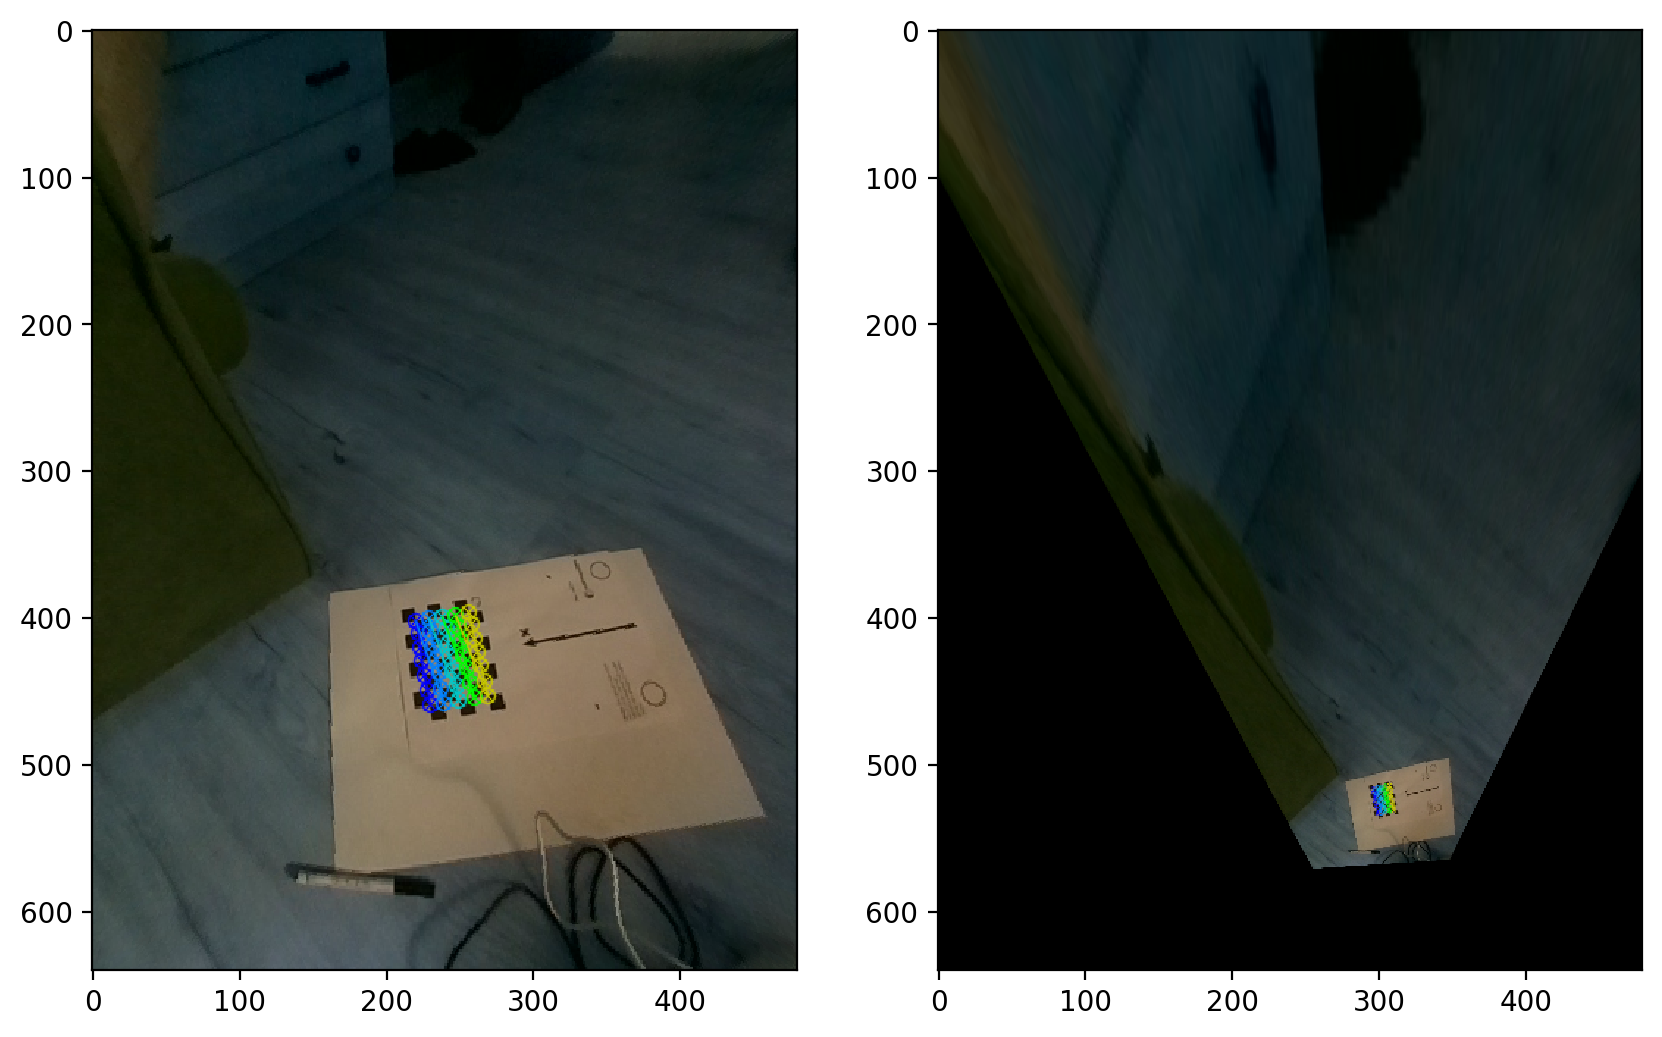

In [28]:
from typing import List

from dt_computer_vision.camera.calibration.extrinsics.chessboard import find_corners

image_rect = camera.rectifier.rectify(image)
corners: List[Pixel] = find_corners(image_rect, board)

# Reverse order of corners
corners = corners[::-1]

# Draw corners on the image
image_w_corners = cv2.drawChessboardCorners(
    image_rect.copy(),
    (board.columns, board.rows),
    np.array([[p.x, p.y] for p in corners], dtype=np.float32),
    True,
)

R2 = np.eye(3)
tvec2 = np.array([0, 0.0, 0.2]).reshape(3, 1)

homography_camera_to_ground = H @ camera.homography_pixel2vector()
homography_ground_to_new_camera = camera.K @ np.hstack((R2[:3,:2], tvec2))
H_synthetic = homography_ground_to_new_camera @ homography_camera_to_ground

img = cv2.warpPerspective(image_w_corners, H_synthetic, (image_rect.shape[1], image_rect.shape[0]))

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(image_w_corners)
ax[1].imshow(img)

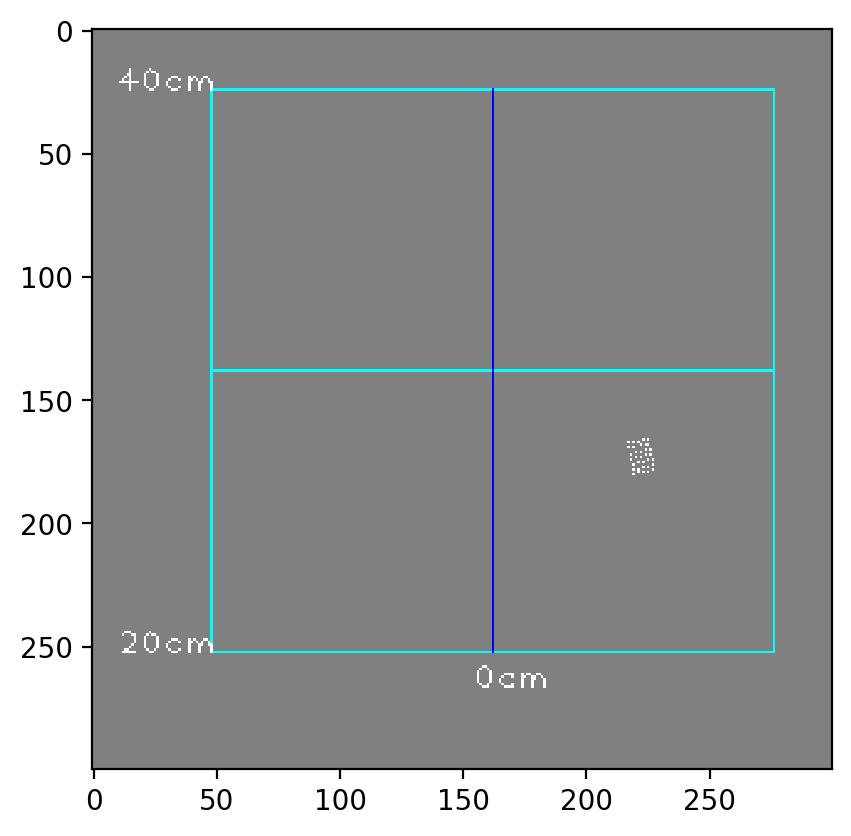

In [29]:
# project segments onto the ground plane
colored_segments = {
    (255, 255, 255): []
}

projector = GroundProjector(camera)

for corner in corners:
    # distorted pixels
    p0: Pixel = corner
    p1: Pixel = p0
    
    # rectified pixel to normalized coordinates
    p0_norm: NormalizedImagePoint = camera.pixel2vector(p0)
    p1_norm: NormalizedImagePoint = p0_norm

    #print(p0_norm)
    # project image point onto the ground plane
    p0_ground: GroundPoint = projector.vector2ground(p0_norm)
    p1_ground: GroundPoint = projector.vector2ground(p1_norm)
    
    
    # add grounded segment to output
    colored_segments[(255, 255, 255)].append((p0_ground, p1_ground))

image_w_projected_segments = debug_image(colored_segments, (300, 300), grid_size=2, s_segment_thickness=2, resolution=0.1,start_y = 0.2)
image_w_projected_segments = cv2.cvtColor(image_w_projected_segments, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(1,1)
ax.imshow(image_w_projected_segments)

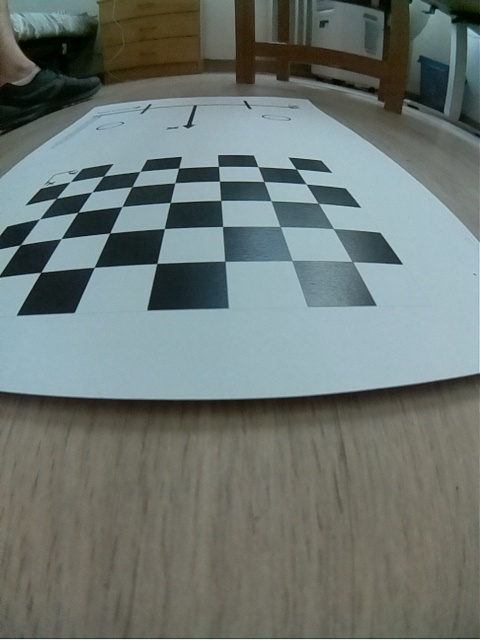

In [42]:
import io
from typing import Optional
import imageio
import rosbags.rosbag1 as rosbag
from rosbags.serde import deserialize_cdr
from dt_computer_vision.camera.calibration.extrinsics.exceptions import NoCornersFoundException
from cv_bridge import CvBridge
import cv2
import os
from IPython.display import display, clear_output
from IPython.core.display import Image
import time

def display_frame(frame, vis_framerate : Optional[float] = None):
    _, buffer = cv2.imencode('.jpg', frame)
    clear_output(wait=True)
    display(Image(data=buffer.tobytes()))
    if vis_framerate is not None:
        time.sleep(1/vis_framerate)

# Function to be executed for each frame
def process_frame(frame, projector : GroundProjector):
    
    image_rect = camera.rectifier.rectify(frame)
    
    try:
        corners: List[Pixel] = find_corners(image_rect, board)

        colored_segments = { (255,255,255):[]}

        for corner in corners:
            # distorted pixels
            p0: Pixel = corner
            p1: Pixel = p0
            
            # rectified pixel to normalized coordinates
            # p0_norm: NormalizedImagePoint = camera.pixel2vector(p0)
            # p1_norm: NormalizedImagePoint = p0_norm

            #print(p0_norm)
            # project image point onto the ground plane
            p0_ground: GroundPoint = projector.vector2ground(p0)
            p1_ground: GroundPoint = projector.vector2ground(p1)
            
            
            # add grounded segment to output
            colored_segments[(255, 255, 255)].append((p0_ground, p1_ground))

        image_w_projected_segments = debug_image(colored_segments, (300, 300), grid_size=2, s_segment_thickness=2, resolution=0.1,start_y = 0.2)
        image_w_projected_segments = cv2.cvtColor(image_w_projected_segments, cv2.COLOR_BGR2RGB)

        return image_w_projected_segments

    except NoCornersFoundException:
        return

# Path to the ROS bag file
bag_file_path = os.path.join(
    assets_dir,
    "extrinsics",
    "dd24",
    "real-world",
    "optical-flow-test.bag"
)

# Topic name for the compressed image
topic_name = "/discovery/camera_node/image/compressed"

# Initialize CvBridge
bridge = CvBridge()

raw_images = []
visualization_images = []

# Open the ROS bag file using rosbags
with rosbag.Reader(bag_file_path) as reader:
    # Iterate over connections and messages
    for connection, timestamp, rawdata in reader.messages():
        try:
            if connection.topic == topic_name:
                # Deserialize the rawdata to a CompressedImage message
                msg = deserialize_cdr(rawdata, connection.msgtype)

                # Convert the CompressedImage to OpenCV image format
                frame = bridge.compressed_imgmsg_to_cv2(msg)

                # Create list of raw and visualization images
                display_frame(frame)
                raw_images.append(frame)
                # vis = process_frame(frame)

                # if vis is not None:
                    # visualization_images.append(vis)
        
        except DeprecationWarning:
            """ TODO:
            Global serialization/deserialization functions have been replaced with explicit typestores.

            If you are deserializing messages from an AnyReader instance, simply
            use its `.deserialize(data, typename)` method.

            Otherwise instantiate a type store and use its methods:

            from rosbags.typesys import Stores, get_typestore

            typestore = get_typestore(Stores.ROS2_FOXY)
            typestore.deserialize_cdr(data, typename)
            msg = deserialize_cdr(rawdata, connection.msgtype)
            """
            continue



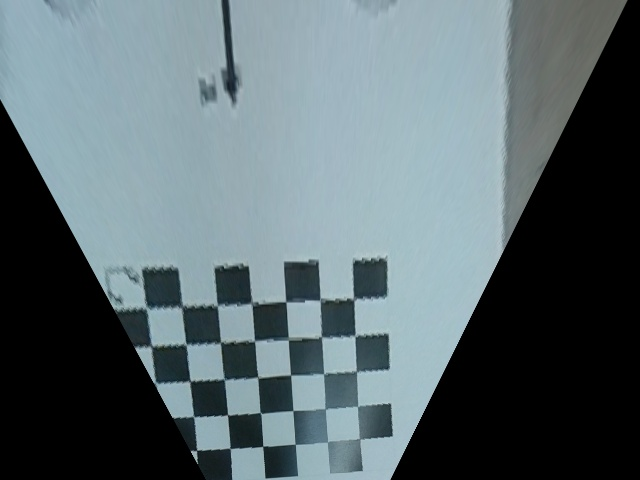

In [43]:
for img in raw_images:
    projected_image = cv2.warpPerspective(
            camera.rectifier.rectify(img),
            H_synthetic,
            img.shape[:2],
        )
    display_frame(projected_image)


In [33]:
camera.H = Homography(H_synthetic)
projector = GroundProjector(camera)

images_to_process = raw_images[300:600:1]
visualization_images = [process_frame(frame, projector) for frame in images_to_process]
# Pop all None values
visualization_images = [image for image in visualization_images if image is not None]

visualization = gif_from_images(visualization_images, 0.1)

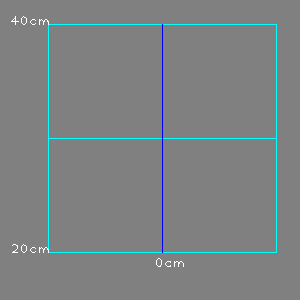

In [34]:
display(visualization)

In [35]:
from matplotlib import pyplot as plt

from dt_computer_vision.camera.homography import interpolate_homography
VIRTUAL_CAMERA_HEIGHT = 0.3

image = cv2.imread(os.path.join(assets_dir, "extrinsics/dd24/real-world/scenario0/image-0.png"))

R2 = np.eye(3)
tvec2 = np.array([0, 0.0, VIRTUAL_CAMERA_HEIGHT]).reshape(3, 1)

H_dt = interpolate_homography(H, tvec2, R2, camera)


Distance: 105.63102395321604 pixels
Pixels per meter: 887.6556634724037


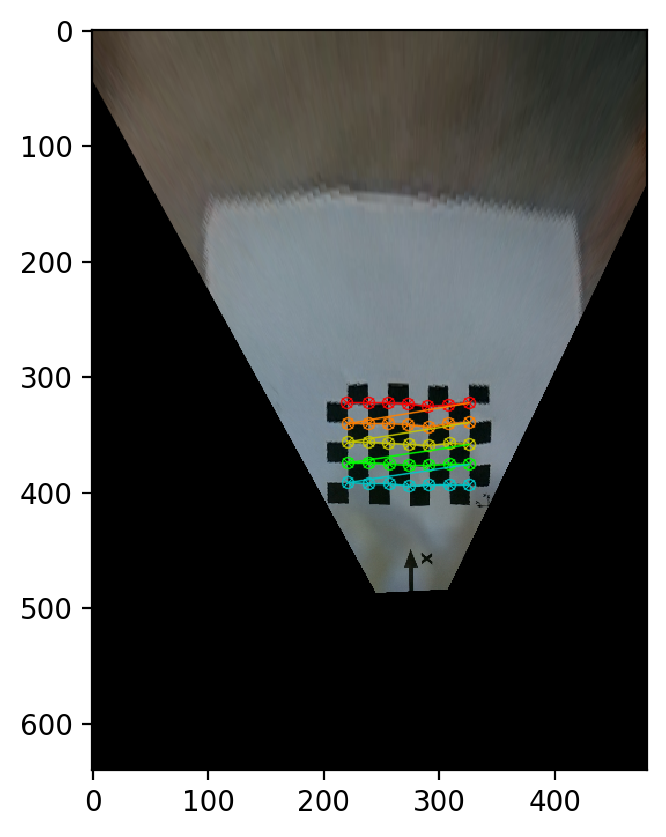

In [36]:
from dt_computer_vision.optical_flow.optical_flow import OpticalFlow
from typing import List
from dt_computer_vision.camera.calibration.extrinsics.chessboard import find_corners

from dt_computer_vision.camera.calibration.extrinsics.boards import CalibrationBoardDD24
board = CalibrationBoardDD24

image_rect = camera.rectifier.rectify(image)

image_projected = cv2.warpPerspective(image_rect, H_dt, (camera.width, camera.height))
image_projected_rgb = cv2.cvtColor(image_projected, cv2.COLOR_BGR2RGB)

corners: List[Pixel] = find_corners(image_rect, board)

projected_corners = [OpticalFlow._project_pixel(p, H_dt) for p in corners]

image_w_corners = cv2.drawChessboardCorners(
    image_projected.copy(),
    (board.columns, board.rows),
    np.array([[p.x, p.y] for p in projected_corners], dtype=np.float32),
    True,
)
plt.imshow(cv2.cvtColor(image_w_corners, cv2.COLOR_BGR2RGB))

# Find the pixel distance between the first and 7th corner
board_width_px = np.linalg.norm((projected_corners[0]-projected_corners[board.columns-1]).as_array())
print(f"Distance: {board_width_px} pixels")
print(f"Pixels per meter: {board_width_px / (board.columns*board.square_size)}")

# Test perspective correction

1. Project the image to the desired view
2. Obtain corner of the original view
3. Generate perspective correction matrix
4. Use it to project the images

[P(128.5543975830078, 159.7707061767578), P(347.33221435546875, 158.13389587402344), P(397.7878112792969, 242.49960327148438), P(79.59259796142578, 237.2989044189453)]
[P(287.4159851074219, 388.0221862792969), P(315.68310546875, 559.7567749023438), P(197.4102020263672, 560.7952880859375), P(200.1920928955078, 398.0776062011719)]
[P(256.0158996582031, 396.1777038574219), P(268.5343933105469, 452.53399658203125), P(229.71080017089844, 459.224609375), P(220.0637969970703, 401.7485046386719)]


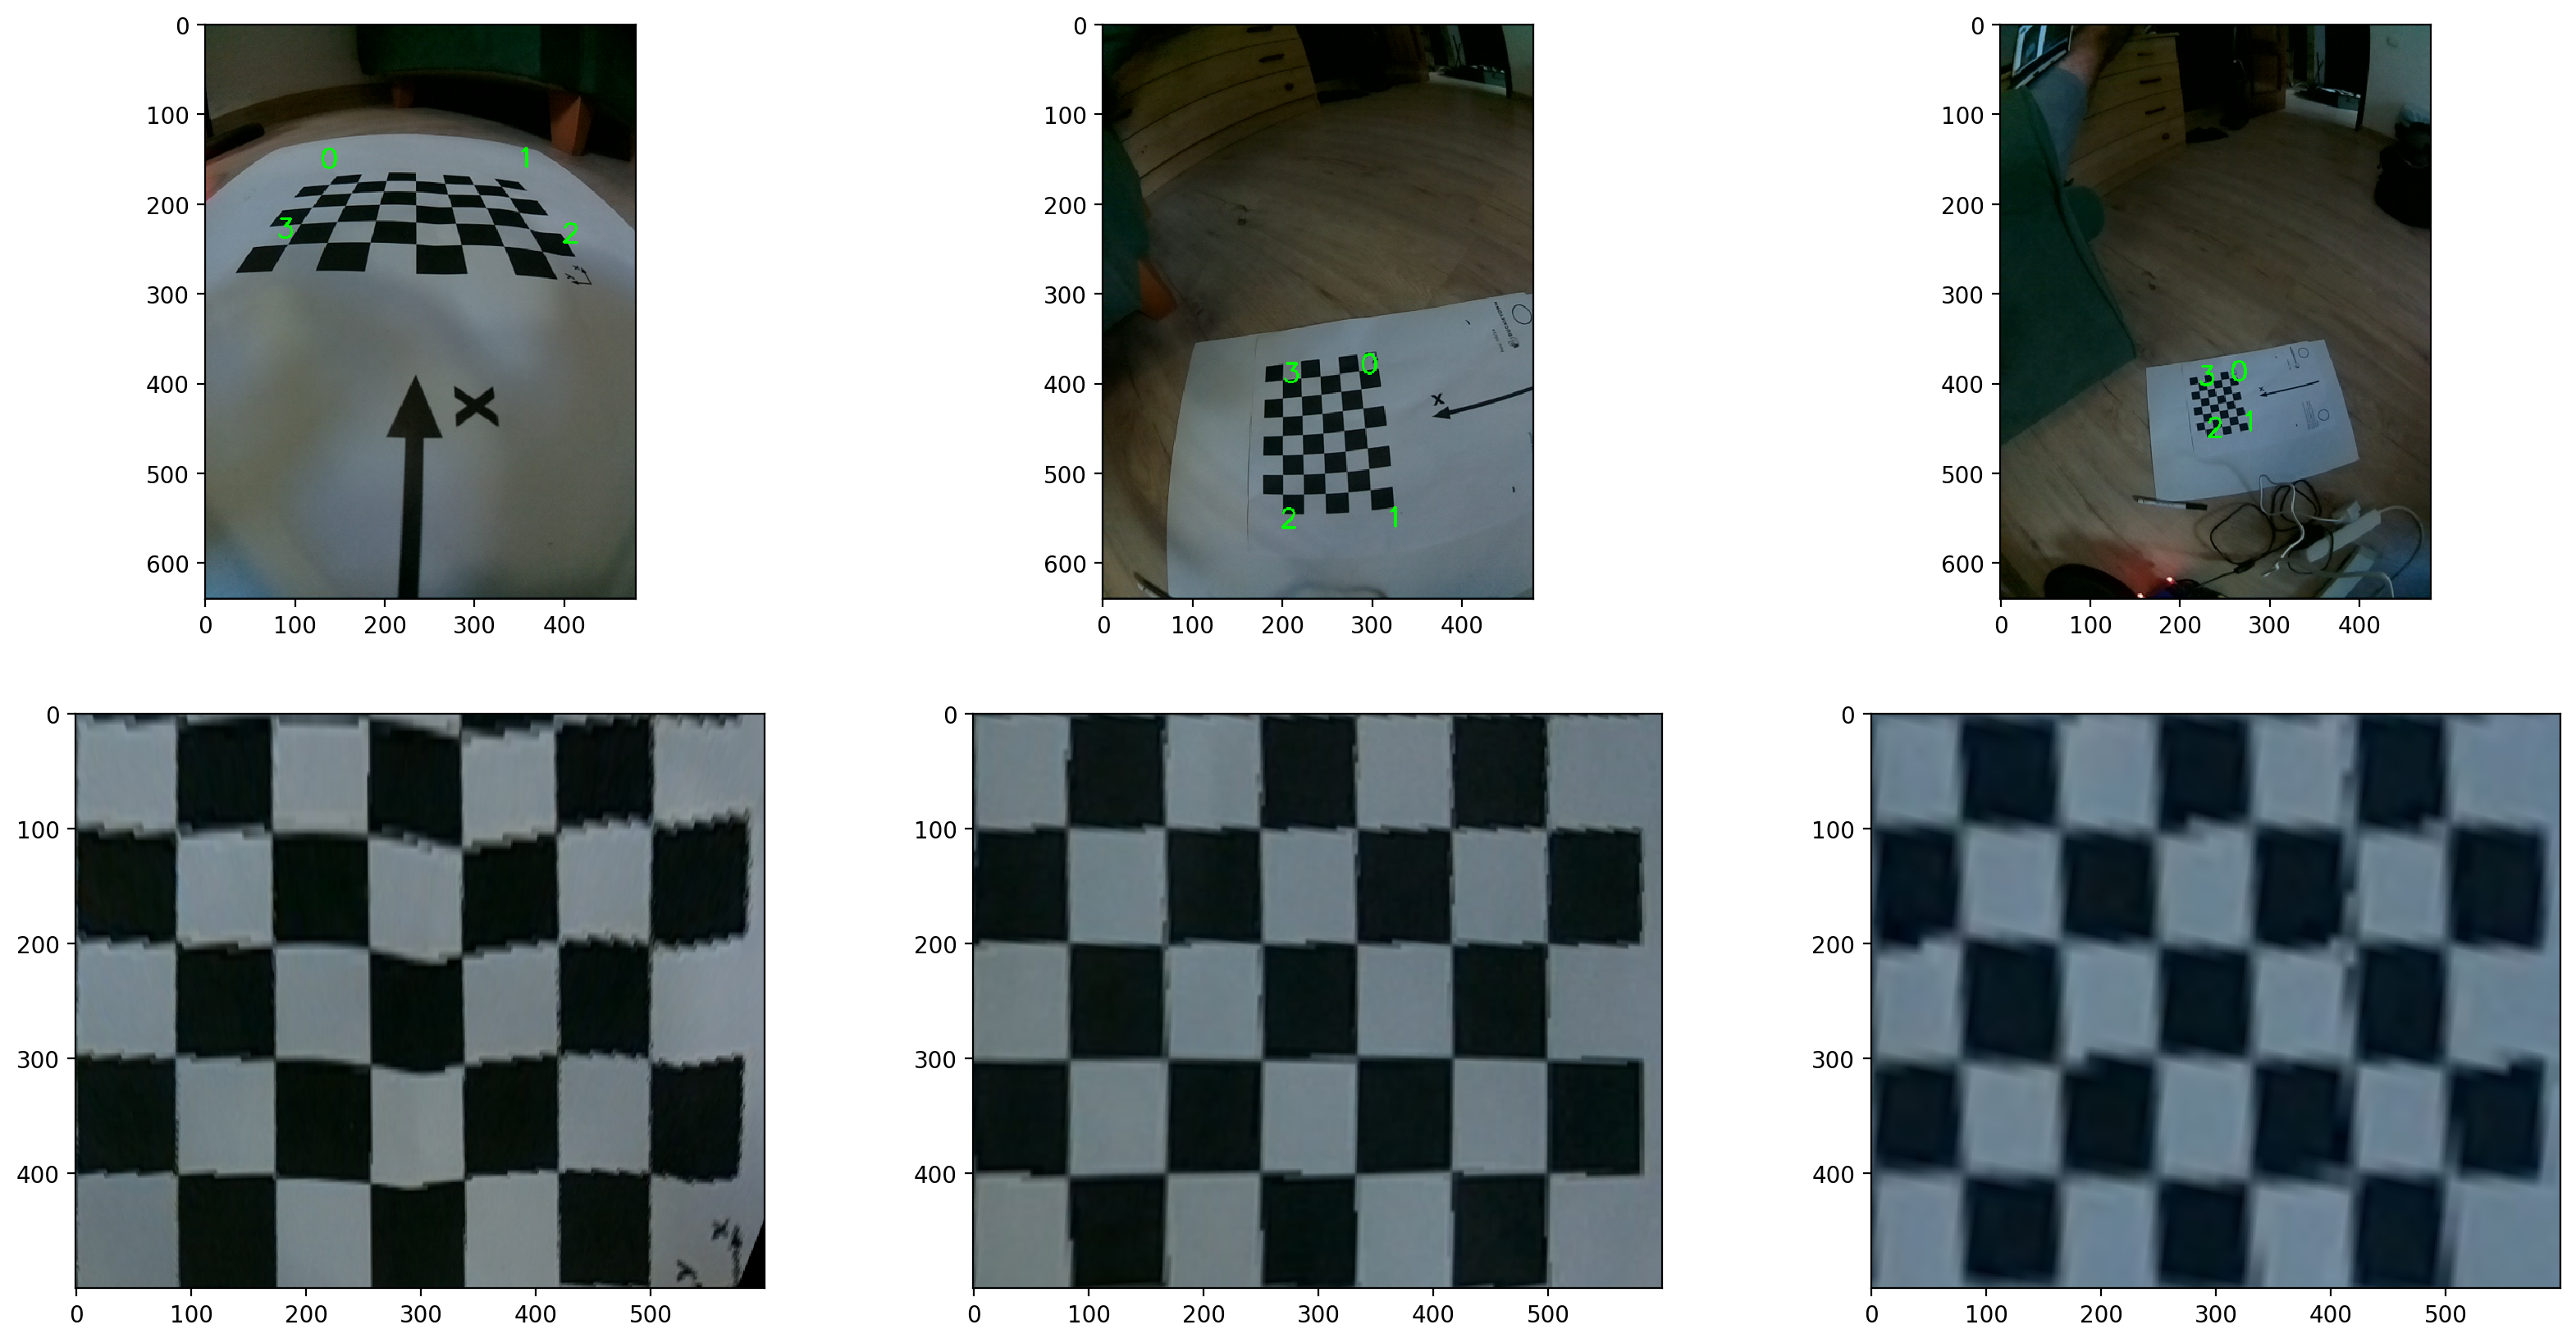

In [37]:
# Convert list of Pixels to array
image = cv2.imread(os.path.join(assets_dir, "extrinsics/dd24/real-world/scenario0/image-0.png"))
image_1 = cv2.imread(os.path.join(assets_dir, "extrinsics/dd24/real-world/scenario1/20cm.png"))
image_2 = cv2.imread(os.path.join(assets_dir, "extrinsics/dd24/real-world/scenario1/50cm.png"))

fig, ax = plt.subplots(2, 3, figsize=(20, 10))

for i, image in enumerate([image, image_1, image_2]):
    image_rect = camera.rectifier.rectify(image)
    corners = find_corners(image_rect, board)
    upper_left = corners[0]
    upper_right = corners[board.columns-1]
    lower_left = corners[-board.columns]
    lower_right = corners[-1]

    pts = [upper_left, upper_right, lower_right, lower_left]
    print(pts)
    # Visualize each point with its number in the image
    vis = image.copy()
    for j, p in enumerate(pts):
        cv2.putText(vis, str(j), (int(p.x), int(p.y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    ax[0,i].imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    
    pts1 = np.array([p.as_array() for p in pts])
    pts2 = np.array([[0,0],[500,0],[500,400],[0,400]], dtype=np.float32)

    M = cv2.getPerspectiveTransform(pts1,pts2)
    dst = cv2.warpPerspective(camera.rectifier.rectify(image),M,(600,500))
    ax[1,i].imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))

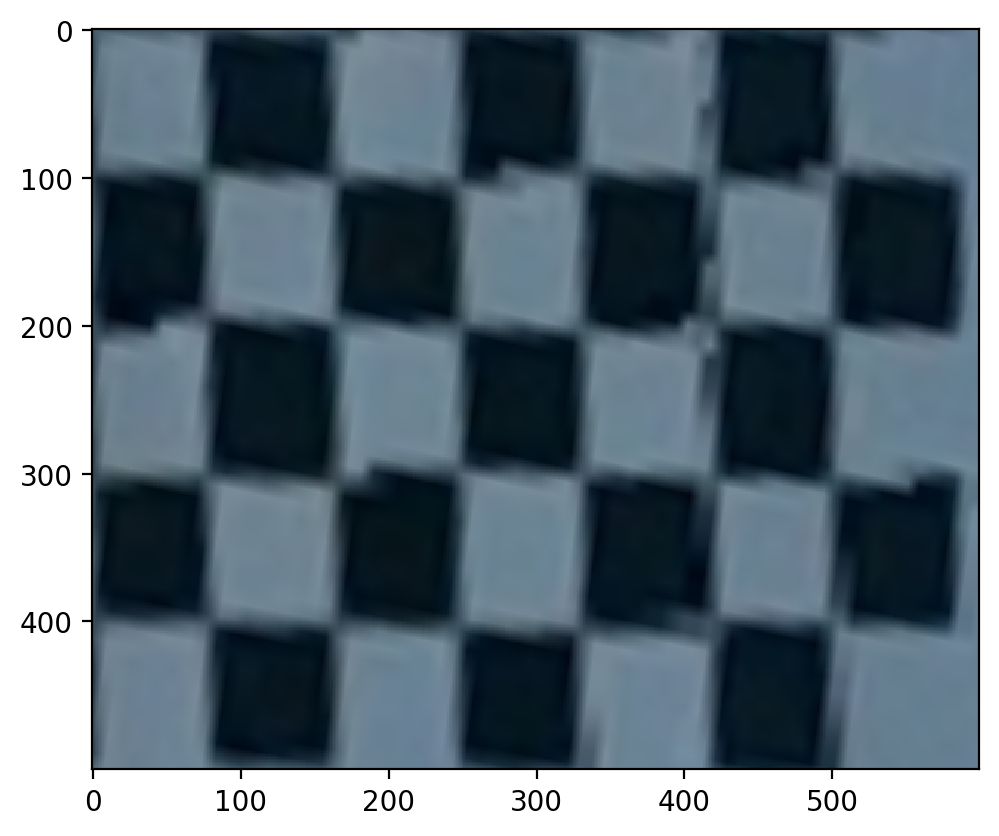

In [38]:

pts1 = np.array([p.as_array() for p in pts])
pts2 = np.array([[0,0],[500,0],[500,400],[0,400]], dtype=np.float32)

assert pts1.shape == (4, 2)
assert pts2.shape == (4, 2)



M = cv2.getPerspectiveTransform(pts1,pts2)
dst = cv2.warpPerspective(camera.rectifier.rectify(image),M,(600,500))
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))

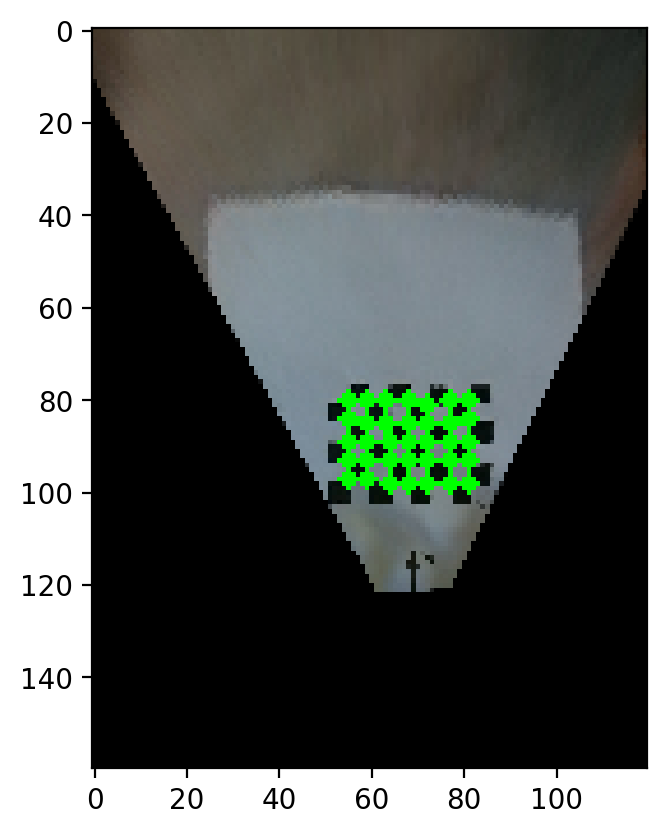

In [39]:
from dt_computer_vision.optical_flow.optical_flow import OpticalFlow

BINNING = 4

optical_flow = OpticalFlow(track_len=10, detect_interval=5, resize_scale=1/BINNING)
vis = optical_flow.create_debug_visualization(
        image_projected, [px/BINNING for px in projected_corners], ''
    )

plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))

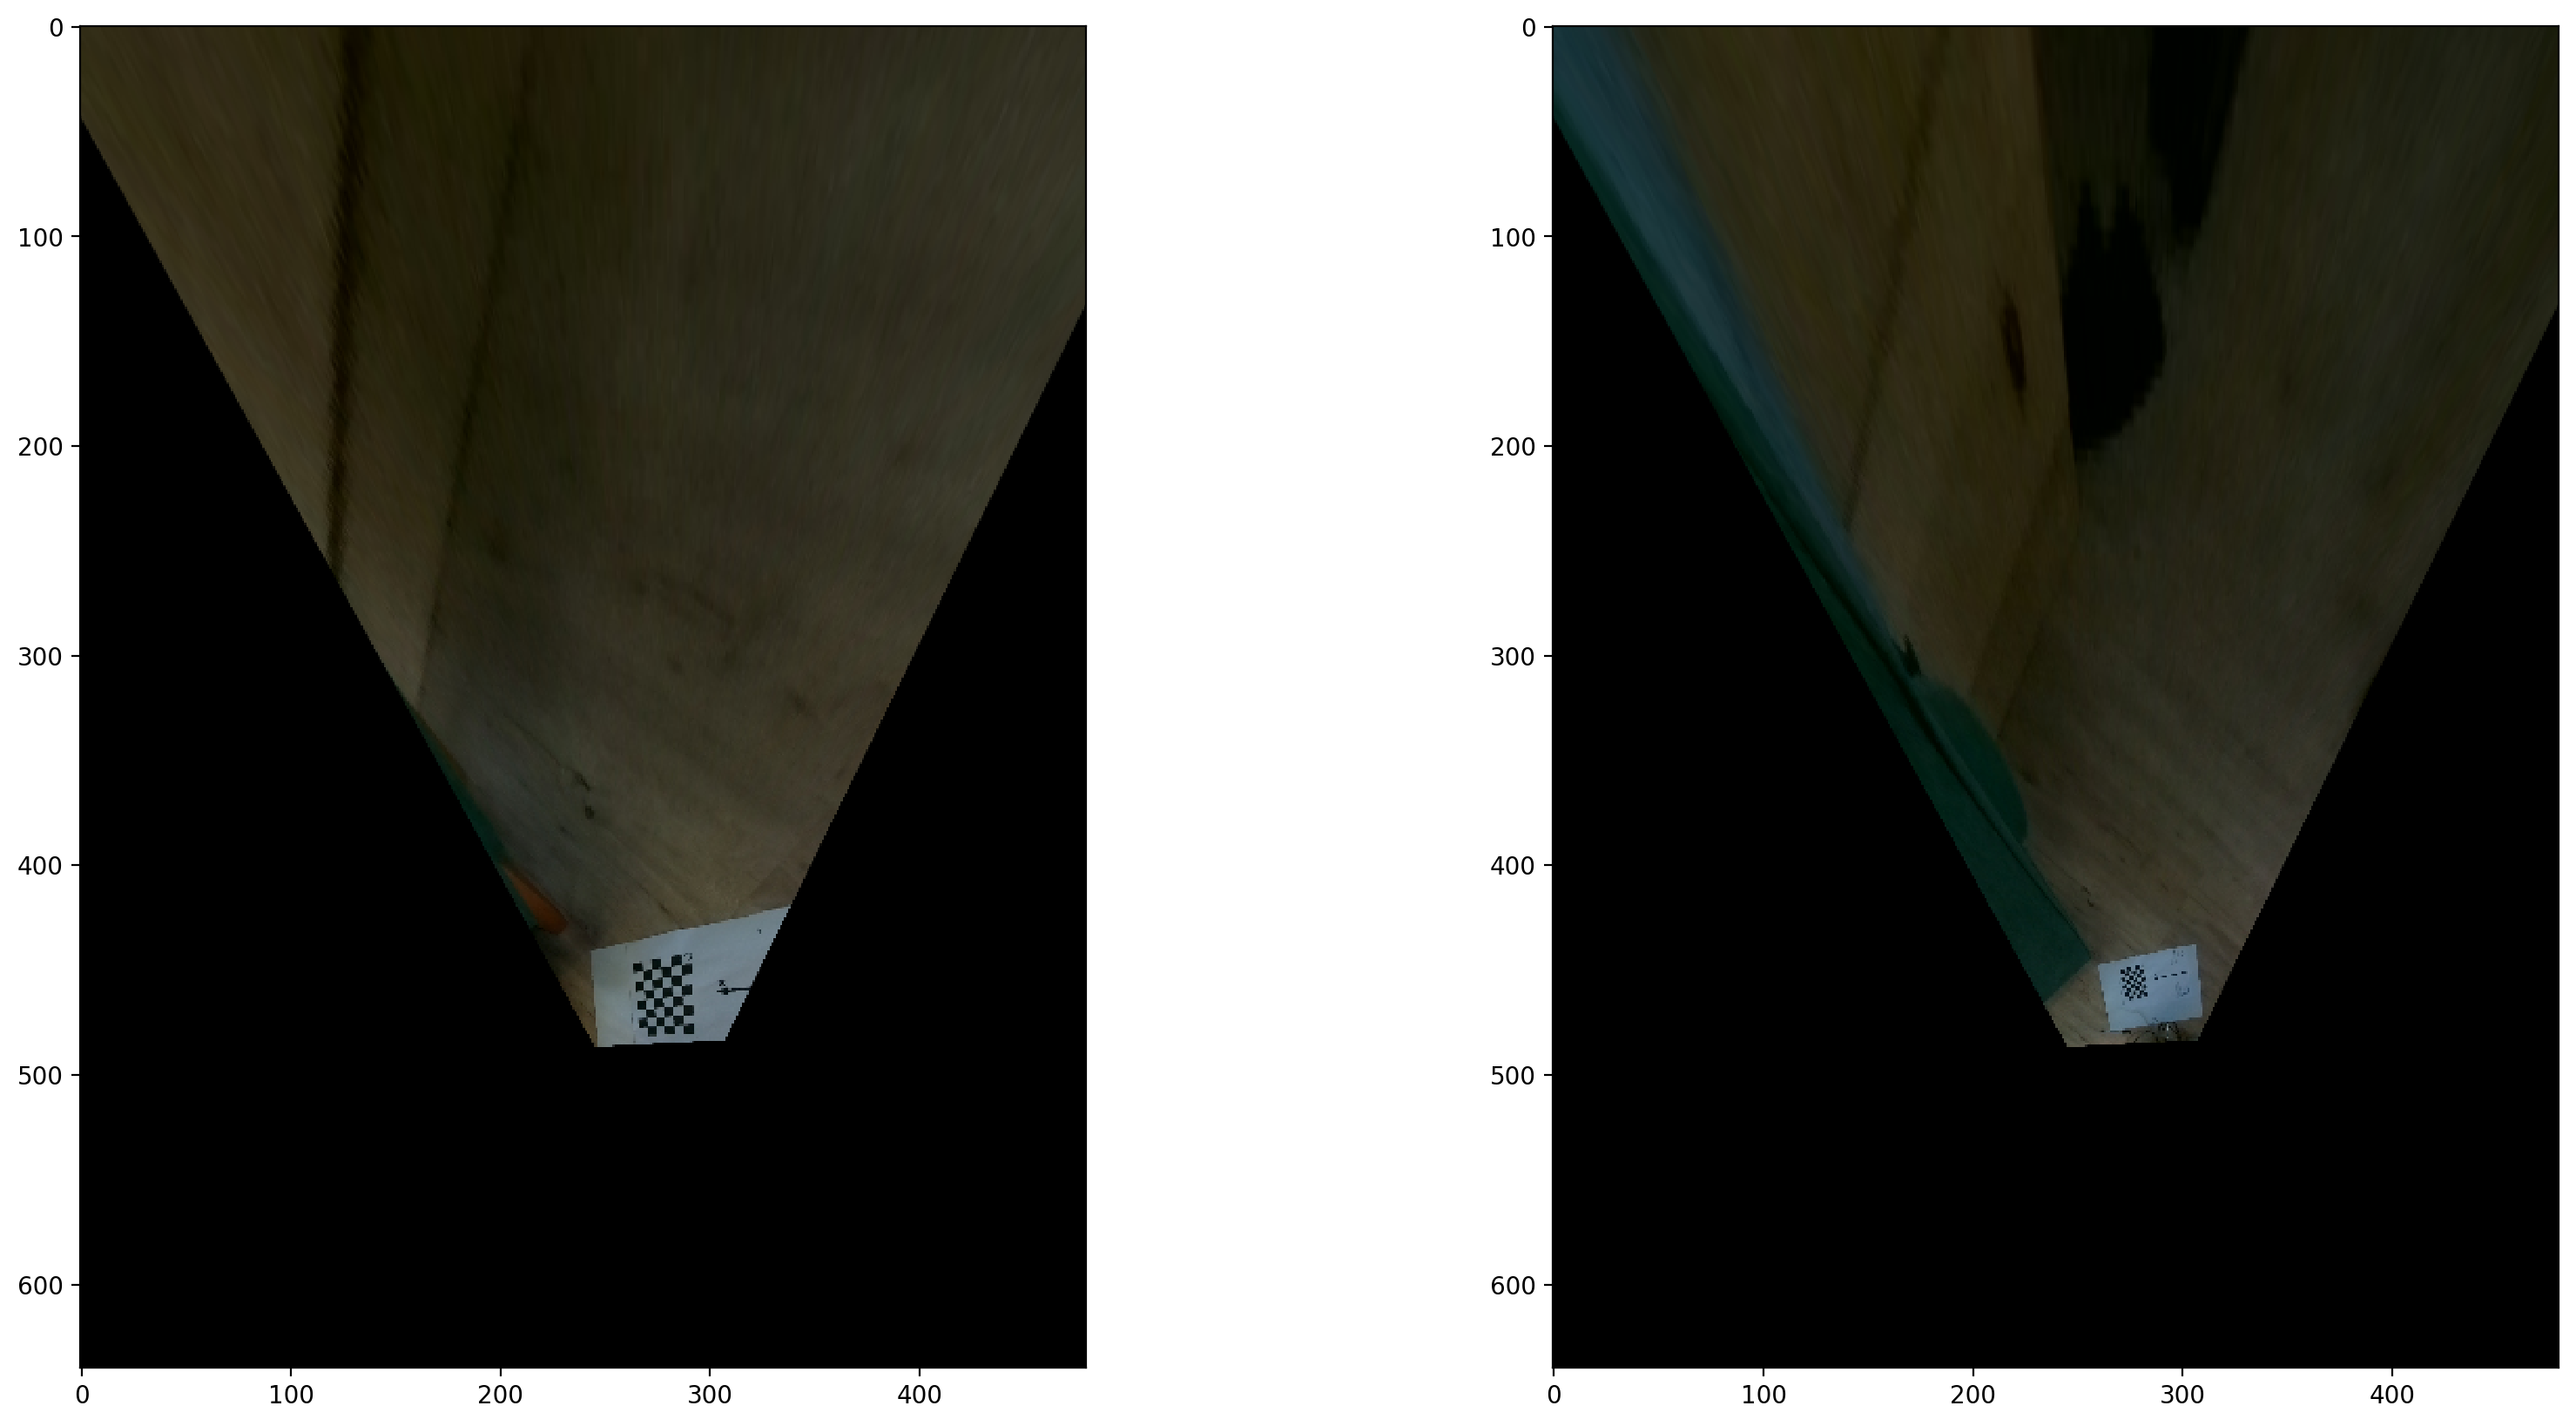

In [40]:
image_1 = cv2.imread(os.path.join(assets_dir, "extrinsics/dd24/real-world/scenario1/20cm.png"))
image_2 = cv2.imread(os.path.join(assets_dir, "extrinsics/dd24/real-world/scenario1/50cm.png"))

# Show the two images side by side
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

for i, image in enumerate([image_1, image_2]):
    image_rect = camera.rectifier.rectify(image)

    image_projected = cv2.warpPerspective(image_rect, H_dt, (camera.width, camera.height))

    ax[i].imshow(cv2.cvtColor(image_projected, cv2.COLOR_BGR2RGB))